# Logistická regrese - kvalita odhadu [30b]

Tento týden jsme dělali logistickou regresi. V ní je laplaceovská aproximace, kde se hledá MAP odhad - na maximum aposteriorní distribuce se nasazuje gausovka. To maximum se hledá Newtonovou iterační metodou. A jako zajímavý projekt by mi přišlo zkusit porovnat:
1) více kroků Newtona (ve skriptu/jupyteru je jen jeden)
2) nějakou numerickou metodu pro hledání maxima (lze použít rovnou ze scipy)

To porovnání by bylo z hlediska rychlosti konvergence odhadů (pro srovnání mi stačí vzít MLE odhady z sklearn).


# Knihovny a helpers

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def plot_cnf_matrix(y_test, y_pred, class_names):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):0.2f}\nF1-score: {f1_score(y_test, y_pred):0.2f}')
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Dataset

Dataset je *Skin Segmentation Dataset (Bhatt & Dhall)*. [Zdroj](https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation).

In [2]:
dpath = Path('ukol2/data')
dfd = pd.read_csv(dpath / 'Skin_NonSkin.txt', sep='\t', header=None)
dfd.columns = ['B', 'G', 'R', 'Class']
dfd = dfd.sample(frac=1).reset_index(drop=True)
display(dfd.head())
print(f'Celkem {len(dfd.index)}')
print(f'Skin {sum(dfd.Class == 1)}')
print(f'No Skin {sum(dfd.Class == 2)}')

X_train, X_test, y_train, y_test = train_test_split(dfd.drop(columns=["Class"]),
                                    dfd.Class, test_size=0.20, random_state=42)

,B,G,R,Class
0,121,124,75,2
1,202,201,163,2
2,89,162,124,2
3,178,176,135,2
4,59,105,169,1


Celkem 245057
Skin 50859
No Skin 194198


# Baseline
Logistická regrese bez použití Bayese.

Accuracy: 0.92
F1-score: 0.81


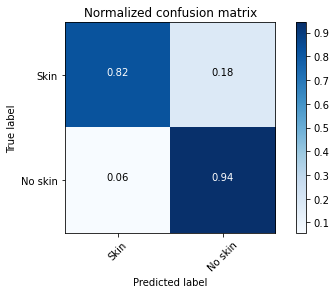

In [5]:
from sklearn.linear_model import LogisticRegression

y_pred = LogisticRegression(random_state=42).fit(X_train, y_train).predict(X_test)
plot_cnf_matrix(y_test, y_pred, ['Skin', 'No skin'])

# Bayes

In [4]:
# apriorni odhad vah (regresnich koeficientu)
mean = (0, 0, 0, 0)
cov = 100*np.eye(4)
apr = np.random.multivariate_normal(mean, cov)